# **Reddit Lens - Troll and Bot Predictor Model**
### ***Decision Tree Classifier vs Random Forest Classifier***

#### **Bots and trolls** are becoming a major perril for social platforms nowadays as their hidden influence upon users seems to trigger unforeseeable effects especially in the political realm. 
#### Trolls might be relatively innocent, merely attempting to enjoy themselves at others’ expense, but they can also be political players fostering suspicion or conflict. While some bots provide useful information, others might be employed to rig election results and spread content that furthers their political objectives. The severity of bot issues is anticipated to worsen as machine learning technology advance.
#### In this scenario, I decided to fight fire with fire and develop a Machine Learning model, which I called **Reddit Lens**, for detecting trolls and bots on subreddit threads while I was trying to compare **Decision Tree and Random Forest Classifiers**.

In [115]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from textblob import TextBlob
import datetime as dt
import difflib
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from IPython import get_ipython
import collections
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.tree import export_graphviz
from sklearn import tree
import pickle

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/redditnormaluserdata/reddit_users.csv
/kaggle/input/reddit-clean-data-v2/reddit_clean_data.csv
/kaggle/input/redditdata/reddit-data.csv


## **Data Cleaning and Normalizing (Trolls and Bots DB)**

In [181]:
with open('../input/redditdata/reddit-data.csv') as f:
    df = pd.read_csv(f, sep=',', dtype={
        "banned_by": str,
        "no_follow": bool,
        "link_id": str,
        "gilded": bool,
        "author": str,
        "author_verified": bool,
        "author_comment_karma": np.float64,
        "author_link_karma": np.float64,
        "num_comments": np.float64,
        "created_utc": np.float64,
        "score": np.float64,
        "over_18": bool,
        "body": str,
        "downs": np.float64,
        "is_submitter": bool,
        "num_reports": np.float64,
        "controversiality": np.float64,
        "quarantine": str,
        "ups": np.float64,
        "is_bot": bool,
        "is_troll": bool,
        "recent_comments": str
    })
    
df['created_utc'] = pd.to_datetime(df['created_utc'].values, unit='s')
df = df.assign(is_normal=False)

print(f"{df.size} bots and trolls raw comments")
df.head()

6141828 bots and trolls raw comments


banned_by  no_follow    link_id  gilded   author  author_verified  \
0       NaN       True  t3_2l5szg   False  ADHDbot            False   
1       NaN       True  t3_2l61gs   False  ADHDbot            False   
2       NaN       True  t3_2l7ma8   False  ADHDbot            False   
3       NaN       True  t3_2l7t5h   False  ADHDbot            False   
4       NaN       True  t3_2l900k   False  ADHDbot            False   

   author_comment_karma  author_link_karma  num_comments         created_utc  \
0                  -6.0                1.0           1.0 2014-11-03 15:02:38   
1                  -6.0                1.0           1.0 2014-11-03 16:21:27   
2                  -6.0                1.0           1.0 2014-11-04 00:21:05   
3                  -6.0                1.0           1.0 2014-11-04 01:23:18   
4                  -6.0                1.0           1.0 2014-11-04 10:15:33   

   ...  downs  is_submitter num_reports  controversiality  quarantine  ups  \
0  ...    0.0         False         NaN               0.0       false  1.0   
1  ...    0.0         False         NaN               0.0       false  1.0   
2  ...    0.0         False         NaN               0.0       false  1.0   
3  ...    0.0         False         NaN               0.0       false  1.0   
4  ...    0.0         False         NaN               0.0       false  1.0   

   is_bot is_troll                                    recent_comments  \
0    True    False                                                 []   
1    True    False  [{"banned_by":null,"no_follow":true,"link_id":...   
2    True    False  [{"banned_by":null,"no_follow":true,"link_id":...   
3    True    False  [{"banned_by":null,"no_follow":true,"link_id":...   
4    True    False  [{"banned_by":null,"no_follow":true,"link_id":...   

   is_normal  
0      False  
1      False  
2      False  
3      False  
4      False  

[5 rows x 23 columns]

## **Data Cleaning and Normalizing (Normal Users DB)**

In [182]:
with open('../input/redditnormaluserdata/reddit_users.csv') as f:
    df_normal = pd.read_csv(f, sep=',', dtype={
        "banned_by": str,
        "no_follow": bool,
        "link_id": str,
        "gilded": bool,
        "author": str,
        "author_verified": bool,
        "author_comment_karma": np.float64,
        "author_link_karma": np.float64,
        "num_comments": np.float64,
        "created_utc": np.float64,
        "score": np.float64,
        "over_18": bool,
        "body": str,
        "downs": np.float64,
        "is_submitter": bool,
        "num_reports": np.float64,
        "controversiality": np.float64,
        "quarantine": str,
        "ups": np.float64,
        "recent_comments": str
    })

df_normal = df_normal.assign(is_bot=False, is_troll=False, is_normal=True)
df_normal['created_utc'] = pd.to_datetime(df_normal['created_utc'].values, unit='s')

print(f"{df_normal.size} normal users raw comments")
df_normal.head()

926762 normal users raw comments


banned_by  no_follow    link_id  gilded             author  author_verified  \
0       NaN       True  t3_zfmq3a   False   IFUCKINGLOVEMETH             True   
1       NaN       True  t3_zfpm82   False    Takethemagsaway             True   
2       NaN       True  t3_zfmmhn   False  CassandraAnderson             True   
3       NaN       True  t3_zfculp   False          tanman729             True   
4       NaN       True  t3_zfmx4g   False     BassReasonable             True   

   author_comment_karma  author_link_karma  num_comments         created_utc  \
0               74046.0            33501.0          98.0 2022-12-08 06:37:57   
1               24895.0               39.0          14.0 2022-12-08 06:37:59   
2              225735.0             7531.0          41.0 2022-12-08 06:38:07   
3               17750.0             1671.0          63.0 2022-12-08 06:37:54   
4                2264.0               31.0          65.0 2022-12-08 06:37:19   

   ...  downs  is_submitter num_reports  controversiality  quarantine  ups  \
0  ...    0.0         False         NaN               0.0       False  1.0   
1  ...    0.0         False         NaN               0.0       False  1.0   
2  ...    0.0         False         NaN               0.0       False  1.0   
3  ...    0.0         False         NaN               0.0       False  1.0   
4  ...    0.0         False         NaN               0.0       False  1.0   

   is_bot is_troll                                    recent_comments  \
0   False    False  [{"banned_by":null,"no_follow":true,"link_id":...   
1   False    False  [{"banned_by":null,"no_follow":true,"link_id":...   
2   False    False  [{"banned_by":null,"no_follow":true,"link_id":...   
3   False    False  [{"banned_by":null,"no_follow":false,"link_id"...   
4   False    False  [{"banned_by":null,"no_follow":true,"link_id":...   

   is_normal  
0       True  
1       True  
2       True  
3       True  
4       True  

[5 rows x 23 columns]

In [183]:
# append normal users to bot/trolls
df = df.append(df_normal)

df.drop_duplicates(inplace=True)
df['body'] = df['body'].str.slice(stop=200).fillna('')

# add a few useful statistics features
df['recent_num_comments'] = pd.Series(np.zeros(len(df.index), np.int64))
df['recent_num_last_30_days'] = pd.Series(np.zeros(len(df.index), np.int64))
df['recent_avg_no_follow'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_avg_gilded'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_avg_responses'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_percent_neg_score'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_avg_score'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_min_score'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_avg_controversiality'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_avg_ups'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_avg_diff_ratio'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_max_diff_ratio'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_avg_sentiment_polarity'] = pd.Series(np.zeros(len(df.index), np.float64))
df['recent_min_sentiment_polarity'] = pd.Series(np.zeros(len(df.index), np.float64))

In [184]:
# reduce only the number of bots to reflect real life scenario (more normal users than bots/trolls),
# as trolls are already proportional to normal users
initial_bot_df = df[df.is_bot == True]
print(f"Number of initial bot comments: {initial_bot_df.size}")
df = df[df.is_bot == False]
df = df.append(initial_bot_df.head(10000))

# Comments
bot_comments = df['is_bot'][df.is_bot == True]
troll_comments = df['is_troll'][df.is_troll == True]
normal_comments = df['is_normal'][df.is_normal == True]

print(f"Number of bot comments after reduce: {len(bot_comments)}")
print(f"Number of troll comments: {len(troll_comments)}")
print(f"Number of normal comments: {len(normal_comments)}")

# Authors
bot_authors = df[df.is_bot == True][['author']]
troll_authors = df[df.is_troll == True][['author']]
normal_authors = df[df.is_normal == True][['author']]

print(f"\nNumber of bot authors: {len(np.unique(bot_authors))}")
print(f"Number of troll authors: {len(np.unique(troll_authors))}")
print(f"Number of normal authors: {len(np.unique(normal_authors))}")

users = df['author'].values
print(f"Total number of users: {len(np.unique(users))}")

Number of initial bot comments: 8179738
Number of bot comments after reduce: 10000
Number of troll comments: 6563
Number of normal comments: 27497

Number of bot authors: 20
Number of troll authors: 153
Number of normal authors: 15997
Total number of users: 16170


In [28]:
def diff_ratio(_a, _b):
    return difflib.SequenceMatcher(a=_a,b=_b).ratio()

def last_30(a, b):
    return a - dt.timedelta(days=30) < pd.to_datetime(b, unit='s')

num = 0;

# computing our added statistics features
def calc_stats(comment):
    # track progress
    global num 
    num += 1
    if(num % 1000 == 0): print(num)
        
    recent_comments = pd.read_json(StringIO(comment['recent_comments']), dtype={
        "banned_by": str,
        "no_follow": bool,
        "link_id": str,
        "gilded": np.float64,
        "author": str,
        "author_verified": bool,
        "author_comment_karma": np.float64,
        "author_link_karma": np.float64,
        "num_comments": np.float64,
        "created_utc": np.float64,
        "score": np.float64,
        "over_18": bool,
        "body": str,
        "downs": np.float64,
        "is_submitter": bool,
        "num_reports": np.float64,
        "controversiality": np.float64,
        "quarantine": bool,
        "ups": np.float64})
    comment['recent_num_comments'] = len(recent_comments)
    
    if len(recent_comments) > 0:
        comment['recent_num_last_30_days'] = recent_comments['created_utc'].apply(lambda x: last_30(comment['created_utc'], x)).sum()
        comment['recent_avg_no_follow'] = recent_comments['no_follow'].mean()
        comment['recent_avg_gilded'] = recent_comments['gilded'].mean()
        comment['recent_avg_responses'] = recent_comments['num_comments'].mean()
        comment['recent_percent_neg_score'] = recent_comments['score'].apply(lambda x: x < 0).mean() * 100
        comment['recent_avg_score'] = recent_comments['score'].mean()
        comment['recent_min_score'] = recent_comments['score'].min()
        comment['recent_avg_controversiality'] = recent_comments['controversiality'].mean()
        comment['recent_avg_ups'] = recent_comments['ups'].mean()
        diff = recent_comments['body'].str.slice(stop=200).fillna('').apply(lambda x: diff_ratio(comment['body'], x))
        comment['recent_avg_diff_ratio'] = diff.mean()
        comment['recent_max_diff_ratio'] = diff.max()
        scores = recent_comments['body'].append(pd.Series(comment['body'])).apply(lambda x: TextBlob(x).sentiment.polarity)
        comment['recent_avg_sentiment_polarity'] = scores.mean()
        comment['recent_min_sentiment_polarity'] = scores.min()
        
    return comment

new_data = df.apply(calc_stats, axis=1)
print("Stats Computation is ready!")

# delete NA values
new_data = new_data[new_data.recent_min_sentiment_polarity.isna() == False]

def setTarget(x):
    if(x.is_bot): 
        return 'bot'
    elif(x.is_troll): 
        return 'troll' 
    else:
        return 'normal'

# Create one column with the target training label
new_data['target'] = new_data.apply(lambda x: setTarget(x), axis=1)

# Delete is_bot and is_troll collumns and add targets column
columns = ['is_bot', 'is_troll', 'is_normal']
new_data.drop(columns, inplace=True, axis=1)

# Delete recent_comments to save space
columns = ['recent_comments']
new_data.drop(columns, inplace=True, axis=1)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
Stats Computation is ready!


In [29]:
new_data.to_csv('./reddit_clean_data.csv', sep=',', index=False)
print("The data cleaning finished correctly!!!")

The data cleaning finished correctly!!!


## **Model Training**

In [244]:
with open('../input/reddit-clean-data-v2/reddit_clean_data.csv') as f:
    init_df = pd.read_csv(f, sep=',')
    
columns = ['banned_by', 'num_reports', 'created_utc']
init_df.drop(columns, inplace=True, axis=1)
init_df.dropna(inplace=True)

# Balance db
# print("-----------Before balancing-----------")
# normal_df = init_df[init_df.target == 'normal'] 
# bot_df = init_df[init_df.target == 'bot']
# troll_df = init_df[init_df.target == 'troll']

# print(f"Number of normal users comments: {normal_df.size}")
# print(f"Number of bot users comments: {bot_df.size}")
# print(f"Number of troll users comments: {troll_df.size}")
# print(f"Total number of comments: {init_df.size}\n")

# init_df = init_df[init_df.target != 'normal']
# df = init_df.append(normal_df.head(len(normal_df) // 2))

# print("-----------After balancing-----------")
# normal_df = df[df.target == 'normal'] 
# bot_df = df[df.target == 'bot']
# troll_df = df[df.target == 'troll']

# print(f"Number of normal users comments: {normal_df.size}")
# print(f"Number of bot users comments: {bot_df.size}")
# print(f"Number of troll users comments: {troll_df.size}")
# print(f"Total number of comments: {df.size}\n")

# Shuffle db
df = init_df.sample(frac=1)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44060 entries, 21116 to 38822
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   no_follow                      44060 non-null  bool   
 1   link_id                        44060 non-null  object 
 2   gilded                         44060 non-null  bool   
 3   author                         44060 non-null  object 
 4   author_verified                44060 non-null  bool   
 5   author_comment_karma           44060 non-null  float64
 6   author_link_karma              44060 non-null  float64
 7   num_comments                   44060 non-null  float64
 8   score                          44060 non-null  float64
 9   over_18                        44060 non-null  bool   
 10  body                           44060 non-null  object 
 11  downs                          44060 non-null  float64
 12  is_submitter                   44060 non-n

no_follow    link_id  gilded          author  author_verified  \
21116       True  t3_zgacwk   False    Mulanisabamf             True   
21785       True  t3_zgtz54   False  Spermpocalypse             True   
1808        True  t3_5b4n88   False      richwilcom             True   
31210       True  t3_zgw6o7   False      Rami_Allam             True   
10308       True  t3_zftctq   False         mud_tug             True   

       author_comment_karma  author_link_karma  num_comments  score  over_18  \
21116              238283.0              468.0       10465.0    1.0     True   
21785                 613.0                1.0           3.0    1.0    False   
1808                  -20.0              635.0          12.0    1.0    False   
31210                   3.0                1.0           2.0    1.0    False   
10308              368219.0           127982.0          14.0    1.0    False   

       ... recent_percent_neg_score  recent_avg_score  recent_min_score  \
21116  ...                      0.0              9.80               1.0   
21785  ...                      0.0              2.60               1.0   
1808   ...                      0.0              1.00               1.0   
31210  ...                      0.0              1.00               1.0   
10308  ...                      5.0              2.75             -69.0   

       recent_avg_controversiality  recent_avg_ups  recent_avg_diff_ratio  \
21116                          0.0            9.80               0.171974   
21785                          0.0            2.60               0.051010   
1808                           0.0            1.00               0.038339   
31210                          0.0            1.00               0.262689   
10308                          0.0            2.75               0.209780   

       recent_max_diff_ratio  recent_avg_sentiment_polarity  \
21116               1.000000                       0.197091   
21785               1.000000                       0.078806   
1808                0.038339                      -0.009444   
31210               1.000000                       0.118519   
10308               1.000000                       0.027754   

       recent_min_sentiment_polarity  target  
21116                      -0.312500  normal  
21785                      -0.200000  normal  
1808                       -0.155556   troll  
31210                      -0.138889  normal  
10308                      -0.450000  normal  

[5 rows x 31 columns]

In [229]:
df[df.target == 'bot'].head()

no_follow    link_id  gilded          author  author_verified  \
39343       True  t3_8bx782   False      AutoInsult             True   
43830       True  t3_30f473   False       CHART_BOT            False   
36421       True  t3_1vs0ci   False  Antiracism_Bot            False   
40740       True  t3_36rpqw   False       BeetusBot            False   
38194       True  t3_3u6gwg   False   AtheismModBot            False   

       author_comment_karma  author_link_karma  num_comments  score  over_18  \
39343                5033.0            11048.0          49.0    1.0    False   
43830                6198.0                3.0           3.0    1.0    False   
36421                 312.0                1.0         121.0    1.0    False   
40740               36938.0               26.0          35.0    3.0    False   
38194                 831.0            10290.0           1.0    1.0    False   

       ... recent_percent_neg_score  recent_avg_score  recent_min_score  \
39343  ...                      0.0             10.65               1.0   
43830  ...                      0.0              1.05               1.0   
36421  ...                      0.0              1.10               1.0   
40740  ...                      0.0              1.90               1.0   
38194  ...                      0.0              1.00               1.0   

       recent_avg_controversiality  recent_avg_ups  recent_avg_diff_ratio  \
39343                          0.0           10.65               0.163733   
43830                          0.0            1.05               0.730000   
36421                          0.0            1.10               0.889279   
40740                          0.0            1.90               0.417500   
38194                          0.0            1.00               0.733265   

       recent_max_diff_ratio  recent_avg_sentiment_polarity  \
39343               0.301887                       0.074969   
43830               0.790000                      -0.066667   
36421               1.000000                       0.004762   
40740               0.465000                      -0.060552   
38194               0.765823                       0.375000   

       recent_min_sentiment_polarity  target  
39343                      -0.449375     bot  
43830                      -0.066667     bot  
36421                       0.000000     bot  
40740                      -0.412500     bot  
38194                       0.375000     bot  

[5 rows x 31 columns]

In [230]:
df[df['target'] == 'bot'].describe()

author_comment_karma  author_link_karma  num_comments         score  \
count          10000.000000        10000.00000  10000.000000  10000.000000   
mean            7915.784600         2025.63370    129.394300      2.231100   
std            12010.160732         4141.29212    654.748913      7.082677   
min               -6.000000            1.00000      1.000000    -36.000000   
25%              831.000000            1.00000      1.000000      1.000000   
50%             2059.000000            3.00000      7.000000      1.000000   
75%             6198.000000          276.00000     53.000000      2.000000   
max            36938.000000        11048.00000  31536.000000    285.000000   

         downs  controversiality           ups  recent_num_comments  \
count  10000.0       10000.00000  10000.000000         10000.000000   
mean       0.0           0.00440      2.231100            19.592000   
std        0.0           0.06619      7.082677             2.340531   
min        0.0           0.00000    -36.000000             0.000000   
25%        0.0           0.00000      1.000000            20.000000   
50%        0.0           0.00000      1.000000            20.000000   
75%        0.0           0.00000      2.000000            20.000000   
max        0.0           1.00000    285.000000            20.000000   

       recent_num_last_30_days  recent_avg_no_follow  ...  \
count             10000.000000          10000.000000  ...   
mean                 19.112800              0.900377  ...   
std                   3.473454              0.175380  ...   
min                   0.000000              0.000000  ...   
25%                  20.000000              0.850000  ...   
50%                  20.000000              1.000000  ...   
75%                  20.000000              1.000000  ...   
max                  20.000000              1.000000  ...   

       recent_avg_responses  recent_percent_neg_score  recent_avg_score  \
count          10000.000000              10000.000000      10000.000000   
mean             127.527377                  1.289829          2.192162   
std              332.128919                  4.648867          2.814839   
min                0.000000                  0.000000        -36.000000   
25%                1.350000                  0.000000          1.000000   
50%               19.650000                  0.000000          1.150000   
75%              109.254167                  0.000000          2.550000   
max             3670.350000                100.000000         35.650000   

       recent_min_score  recent_avg_controversiality  recent_avg_ups  \
count      10000.000000                 10000.000000    10000.000000   
mean          -0.034200                     0.004089        2.192162   
std            3.364426                     0.017651        2.814839   
min          -36.000000                     0.000000      -36.000000   
25%            0.000000                     0.000000        1.000000   
50%            1.000000                     0.000000        1.150000   
75%            1.000000                     0.000000        2.550000   
max            5.000000                     0.150000       35.650000   

       recent_avg_diff_ratio  recent_max_diff_ratio  \
count           10000.000000           10000.000000   
mean                0.580222               0.743166   
std                 0.293861               0.294095   
min                 0.000000               0.000000   
25%                 0.397250               0.585000   
50%                 0.706000               0.865000   
75%                 0.796054               0.965000   
max                 1.000000               1.000000   

       recent_avg_sentiment_polarity  recent_min_sentiment_polarity  
count                   10000.000000                   10000.000000  
mean                        0.073775                      -0.126566  
std                         0.183800                       0.337163  
min          

In [231]:
df[df.target == 'troll'].head()

no_follow    link_id  gilded        author  author_verified  \
4175       True  t3_4xmpkn   False       deusXYX             True   
3991       True  t3_4h77uo   False  Maxwel_Terry             True   
3100       True  t3_7jz991   False   dandy1crown             True   
3245      False  t3_7jqmp7   False        Fungon             True   
960        True  t3_41fn9s   False   1488reasons             True   

      author_comment_karma  author_link_karma  num_comments  score  over_18  \
4175                1138.0            14413.0          16.0    2.0    False   
3991                 258.0            14611.0           5.0    1.0    False   
3100                2025.0             1487.0          78.0    1.0    False   
3245                3072.0              454.0         163.0    5.0    False   
960                   96.0                1.0          76.0    7.0    False   

      ... recent_percent_neg_score  recent_avg_score  recent_min_score  \
4175  ...                 0.000000          0.000000               0.0   
3991  ...                15.000000          5.350000              -4.0   
3100  ...                 0.000000          1.500000               0.0   
3245  ...                 0.000000         12.142857               1.0   
960   ...                14.285714          3.285714              -2.0   

      recent_avg_controversiality  recent_avg_ups  recent_avg_diff_ratio  \
4175                         0.00        0.000000               0.000000   
3991                         0.15        5.350000               0.184301   
3100                         0.00        1.500000               0.227574   
3245                         0.00       12.142857               0.198293   
960                          0.00        3.285714               0.151162   

      recent_max_diff_ratio  recent_avg_sentiment_polarity  \
4175               0.000000                       0.000000   
3991               0.384615                       0.120393   
3100               0.370370                       0.277955   
3245               0.288288                       0.109802   
960                0.349462                      -0.003553   

      recent_min_sentiment_polarity  target  
4175                       0.000000   troll  
3991                      -0.400000   troll  
3100                      -0.288889   troll  
3245                      -0.125000   troll  
960                       -0.500000   troll  

[5 rows x 31 columns]

In [232]:
df[df['target'] == 'troll'].describe()

author_comment_karma  author_link_karma  num_comments         score  \
count           6563.000000        6563.000000   6563.000000   6563.000000   
mean            1872.454365       13253.685357    476.881152     17.949718   
std             5480.704868       16990.166808   2391.579689    499.305178   
min              -20.000000           1.000000      1.000000   -145.000000   
25%              108.000000         366.000000      7.000000      1.000000   
50%              453.000000        1487.000000     31.000000      1.000000   
75%             1138.000000       20663.000000    191.000000      2.000000   
max            32373.000000       45367.000000  75370.000000  22893.000000   

        downs  controversiality           ups  recent_num_comments  \
count  6563.0       6563.000000   6563.000000          6563.000000   
mean      0.0          0.037330     17.949718            17.202804   
std       0.0          0.189585    499.305178             5.839349   
min       0.0          0.000000   -145.000000             0.000000   
25%       0.0          0.000000      1.000000            20.000000   
50%       0.0          0.000000      1.000000            20.000000   
75%       0.0          0.000000      2.000000            20.000000   
max       0.0          1.000000  22893.000000            20.000000   

       recent_num_last_30_days  recent_avg_no_follow  ...  \
count              6563.000000           6563.000000  ...   
mean                 16.195185              0.908841  ...   
std                   6.363458              0.177195  ...   
min                   0.000000              0.000000  ...   
25%                  14.000000              0.900000  ...   
50%                  20.000000              0.950000  ...   
75%                  20.000000              1.000000  ...   
max                  20.000000              1.000000  ...   

       recent_avg_responses  recent_percent_neg_score  recent_avg_score  \
count           6563.000000               6563.000000       6563.000000   
mean             479.565610                  8.223638         17.603796   
std              843.671628                 12.266532        232.647935   
min                0.000000                  0.000000        -10.000000   
25%               33.850000                  0.000000          1.000000   
50%              137.450000                  5.000000          1.500000   
75%              567.341667                 10.000000          2.650000   
max             8548.000000                100.000000       4330.850000   

       recent_min_score  recent_avg_controversiality  recent_avg_ups  \
count       6563.000000                  6563.000000     6563.000000   
mean          -3.708213                     0.037894       17.603796   
std           10.604944                     0.070198      232.647935   
min         -145.000000                     0.000000      -10.000000   
25%           -5.000000                     0.000000        1.000000   
50%           -1.000000                     0.000000        1.500000   
75%            0.000000                     0.050000        2.650000   
max          174.000000                     1.000000     4330.850000   

       recent_avg_diff_ratio  recent_max_diff_ratio  \
count            6563.000000            6563.000000   
mean                0.178661               0.338565   
std                 0.063724               0.126211   
min                 0.000000               0.000000   
25%                 0.150000               0.290909   
50%                 0.184289               0.333333   
75%                 0.214259               0.378788   
max                 0.800000               1.000000   

       recent_avg_sentiment_polarity  recent_min_sentiment_polarity  
count                    6563.000000                    6563.000000  
mean                        0.114168                      -0.417268  
std                         0.097433                       0.287153  
min                   

In [233]:
df[df.target == 'normal'].head()

no_follow    link_id  gilded            author  author_verified  \
13990      False  t3_zeo094   False          UTFR_TOM             True   
19288       True  t3_zfyghh   False        gonzot1978             True   
14846       True  t3_zfew2z   False         UCredpill             True   
10274       True  t3_zfvg9a   False  Curious_Shoe9523             True   
13026       True  t3_zfvusx   False       DustyTree78             True   

       author_comment_karma  author_link_karma  num_comments  score  over_18  \
13990               11952.0             8326.0        8025.0    1.0    False   
19288                1785.0              130.0        4356.0    1.0    False   
14846               17094.0                1.0       22666.0    1.0    False   
10274                   9.0                1.0           2.0    1.0    False   
13026                  32.0                1.0          15.0    1.0    False   

       ... recent_percent_neg_score  recent_avg_score  recent_min_score  \
13990  ...                      0.0         10.850000               1.0   
19288  ...                     15.0          0.300000             -15.0   
14846  ...                      0.0         17.800000               1.0   
10274  ...                      0.0          1.166667               0.0   
13026  ...                      0.0          1.000000               1.0   

       recent_avg_controversiality  recent_avg_ups  recent_avg_diff_ratio  \
13990                         0.00       10.850000               0.252048   
19288                         0.00        0.300000               0.275842   
14846                         0.05       17.800000               0.126119   
10274                         0.00        1.166667               0.217170   
13026                         0.00        1.000000               0.221584   

       recent_max_diff_ratio  recent_avg_sentiment_polarity  \
13990                    1.0                       0.249575   
19288                    1.0                      -0.013889   
14846                    1.0                       0.005206   
10274                    1.0                       0.051234   
13026                    1.0                       0.091226   

       recent_min_sentiment_polarity  target  
13990                      -0.400000  normal  
19288                      -0.800000  normal  
14846                      -0.433333  normal  
10274                      -0.600000  normal  
13026                      -0.437500  normal  

[5 rows x 31 columns]

In [234]:
df[df['target'] == 'normal'].describe()

author_comment_karma  author_link_karma  num_comments         score  \
count          1.374800e+04       1.374800e+04  13748.000000  13748.000000   
mean           4.441873e+04       8.186384e+03   2185.752982      1.001527   
std            1.630009e+05       1.395071e+05   6394.150365      0.054591   
min           -1.000000e+02       1.000000e+00      1.000000      0.000000   
25%            5.357500e+02       4.000000e+00      9.000000      1.000000   
50%            5.905500e+03       2.440000e+02     53.000000      1.000000   
75%            3.222425e+04       2.308000e+03    643.500000      1.000000   
max            3.580366e+06       1.487766e+07  38965.000000      4.000000   

         downs  controversiality           ups  recent_num_comments  \
count  13748.0           13748.0  13748.000000         13748.000000   
mean       0.0               0.0      1.001527            19.069974   
std        0.0               0.0      0.054591             3.504569   
min        0.0               0.0      0.000000             1.000000   
25%        0.0               0.0      1.000000            20.000000   
50%        0.0               0.0      1.000000            20.000000   
75%        0.0               0.0      1.000000            20.000000   
max        0.0               0.0      4.000000            20.000000   

       recent_num_last_30_days  recent_avg_no_follow  ...  \
count             13748.000000          13748.000000  ...   
mean                 17.613398              0.742378  ...   
std                   5.356989              0.277512  ...   
min                   1.000000              0.000000  ...   
25%                  20.000000              0.650000  ...   
50%                  20.000000              0.850000  ...   
75%                  20.000000              0.950000  ...   
max                  20.000000              1.000000  ...   

       recent_avg_responses  recent_percent_neg_score  recent_avg_score  \
count          13748.000000              13748.000000      13748.000000   
mean            1338.250627                  2.650399          8.412748   
std             2578.199192                  5.514176         31.924926   
min                1.000000                  0.000000        -26.650000   
25%               75.900000                  0.000000          1.200000   
50%              447.375000                  0.000000          2.400000   
75%             1516.087500                  5.000000          6.150000   
max            36264.000000                 70.000000       1705.950000   

       recent_min_score  recent_avg_controversiality  recent_avg_ups  \
count      13748.000000                 13748.000000    13748.000000   
mean          -2.078411                     0.015007        8.412748   
std           12.486278                     0.035074       31.924926   
min         -561.000000                     0.000000      -26.650000   
25%           -1.000000                     0.000000        1.200000   
50%            1.000000                     0.000000        2.400000   
75%            1.000000                     0.000000        6.150000   
max            2.000000                     0.400000     1705.950000   

       recent_avg_diff_ratio  recent_max_diff_ratio  \
count           13748.000000           13748.000000   
mean                0.222216               0.996703   
std                 0.104174               0.050241   
min                 0.028250               0.060000   
25%                 0.178386               1.000000   
50%                 0.211649               1.000000   
75%                 0.244757               1.000000   
max                 1.000000               1.000000   

       recent_avg_sentiment_polarity  recent_min_sentiment_polarity  
count                   13748.000000                   13748.000000  
mean                        0.074498                      -0.430176  
std                         0.085096                       0.264893  
min          

### Convert categorical data to numeric data

In [245]:
# Number of targets
targets = collections.Counter(df['target'])
print(targets)

# Extract feature and target np arrays (inputs for placeholders)
input_y = df['target'].values
input_x = df.drop(['target'], axis=1)

# Convert categorical data to numeric data using LabelEncoder
def label_encode(data_frame):
    le = preprocessing.LabelEncoder()
    for column_name in data_frame.columns:
        if data_frame[column_name].dtype == object:
            data_frame[column_name] = le.fit_transform(data_frame[column_name])
        else:
            pass

Counter({'normal': 27497, 'bot': 10000, 'troll': 6563})


### Plot confusion matrix for given classifier

In [247]:
def plot_cm(clf, X_data, y_data):
    color = 'blue'
    matrix = plot_confusion_matrix(clf, X_data, y_data, cmap=plt.cm.Blues)
    matrix.ax_.set_title('Confusion Matrix', color=color)
    plt.xlabel('Predicted Label', color=color)
    plt.ylabel('True Label', color=color)
    plt.gcf().axes[0].tick_params(colors=color)
    plt.gcf().axes[1].tick_params(colors=color)
    plt.show()

### **Setup training and test data samples**

In [251]:
X_train, X_test, y_train, y_test = train_test_split(input_x, input_y, test_size=0.4, random_state=40)

### **Decision Tree Classifier Model**

In [252]:
# Create a Decision Tree Classifier
tree_clf = DecisionTreeClassifier(max_depth=5, criterion='gini', min_samples_leaf=100)

# Train the model using the training sets y_pred=clf.predict(X_test)
label_encode(X_train)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=100)

### Prediction on Test Set


------------------Confusion Matrix------------------
Predicted   bot  normal  troll    All
True                                 
bot        4009       0      0   4009
normal      105    1720   9186  11011
troll         0       0   2604   2604
All        4114    1720  11790  17624


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


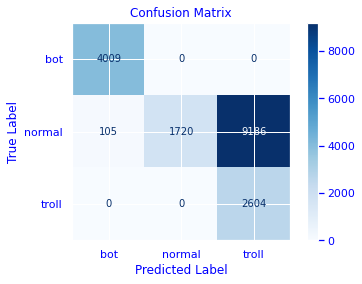


------------------Classification Report------------------
              precision    recall  f1-score   support

         bot       0.97      1.00      0.99      4009
      normal       1.00      0.16      0.27     11011
       troll       0.22      1.00      0.36      2604

    accuracy                           0.47     17624
   macro avg       0.73      0.72      0.54     17624
weighted avg       0.88      0.47      0.45     17624

link_id                          0.664198
author                           0.314420
author_link_karma                0.016860
author_verified                  0.004436
recent_max_diff_ratio            0.000086
no_follow                        0.000000
recent_avg_score                 0.000000
recent_avg_gilded                0.000000
recent_avg_responses             0.000000
recent_percent_neg_score         0.000000
recent_avg_ups                   0.000000
recent_min_score                 0.000000
recent_avg_controversiality      0.000000
recent_num_las

In [253]:
# prediction on test set
label_encode(X_test)
y_pred = tree_clf.predict(X_test)
y_true = y_test

# confusion matrix
print('\n------------------Confusion Matrix------------------')
matrix = pd.crosstab(y_true, y_pred, rownames=['True'],
                     colnames=['Predicted'], margins=True)
print(matrix)
plot_cm(tree_clf, X_test, y_test)

# classification report
print('\n------------------Classification Report------------------')
print(classification_report(y_true, y_pred))

# feature importance
feature_imp = pd.Series(
        tree_clf.feature_importances_,
        index=df.columns.drop('target')).sort_values(ascending=False)
print(feature_imp)

### Decision Tree Classifier Diagram

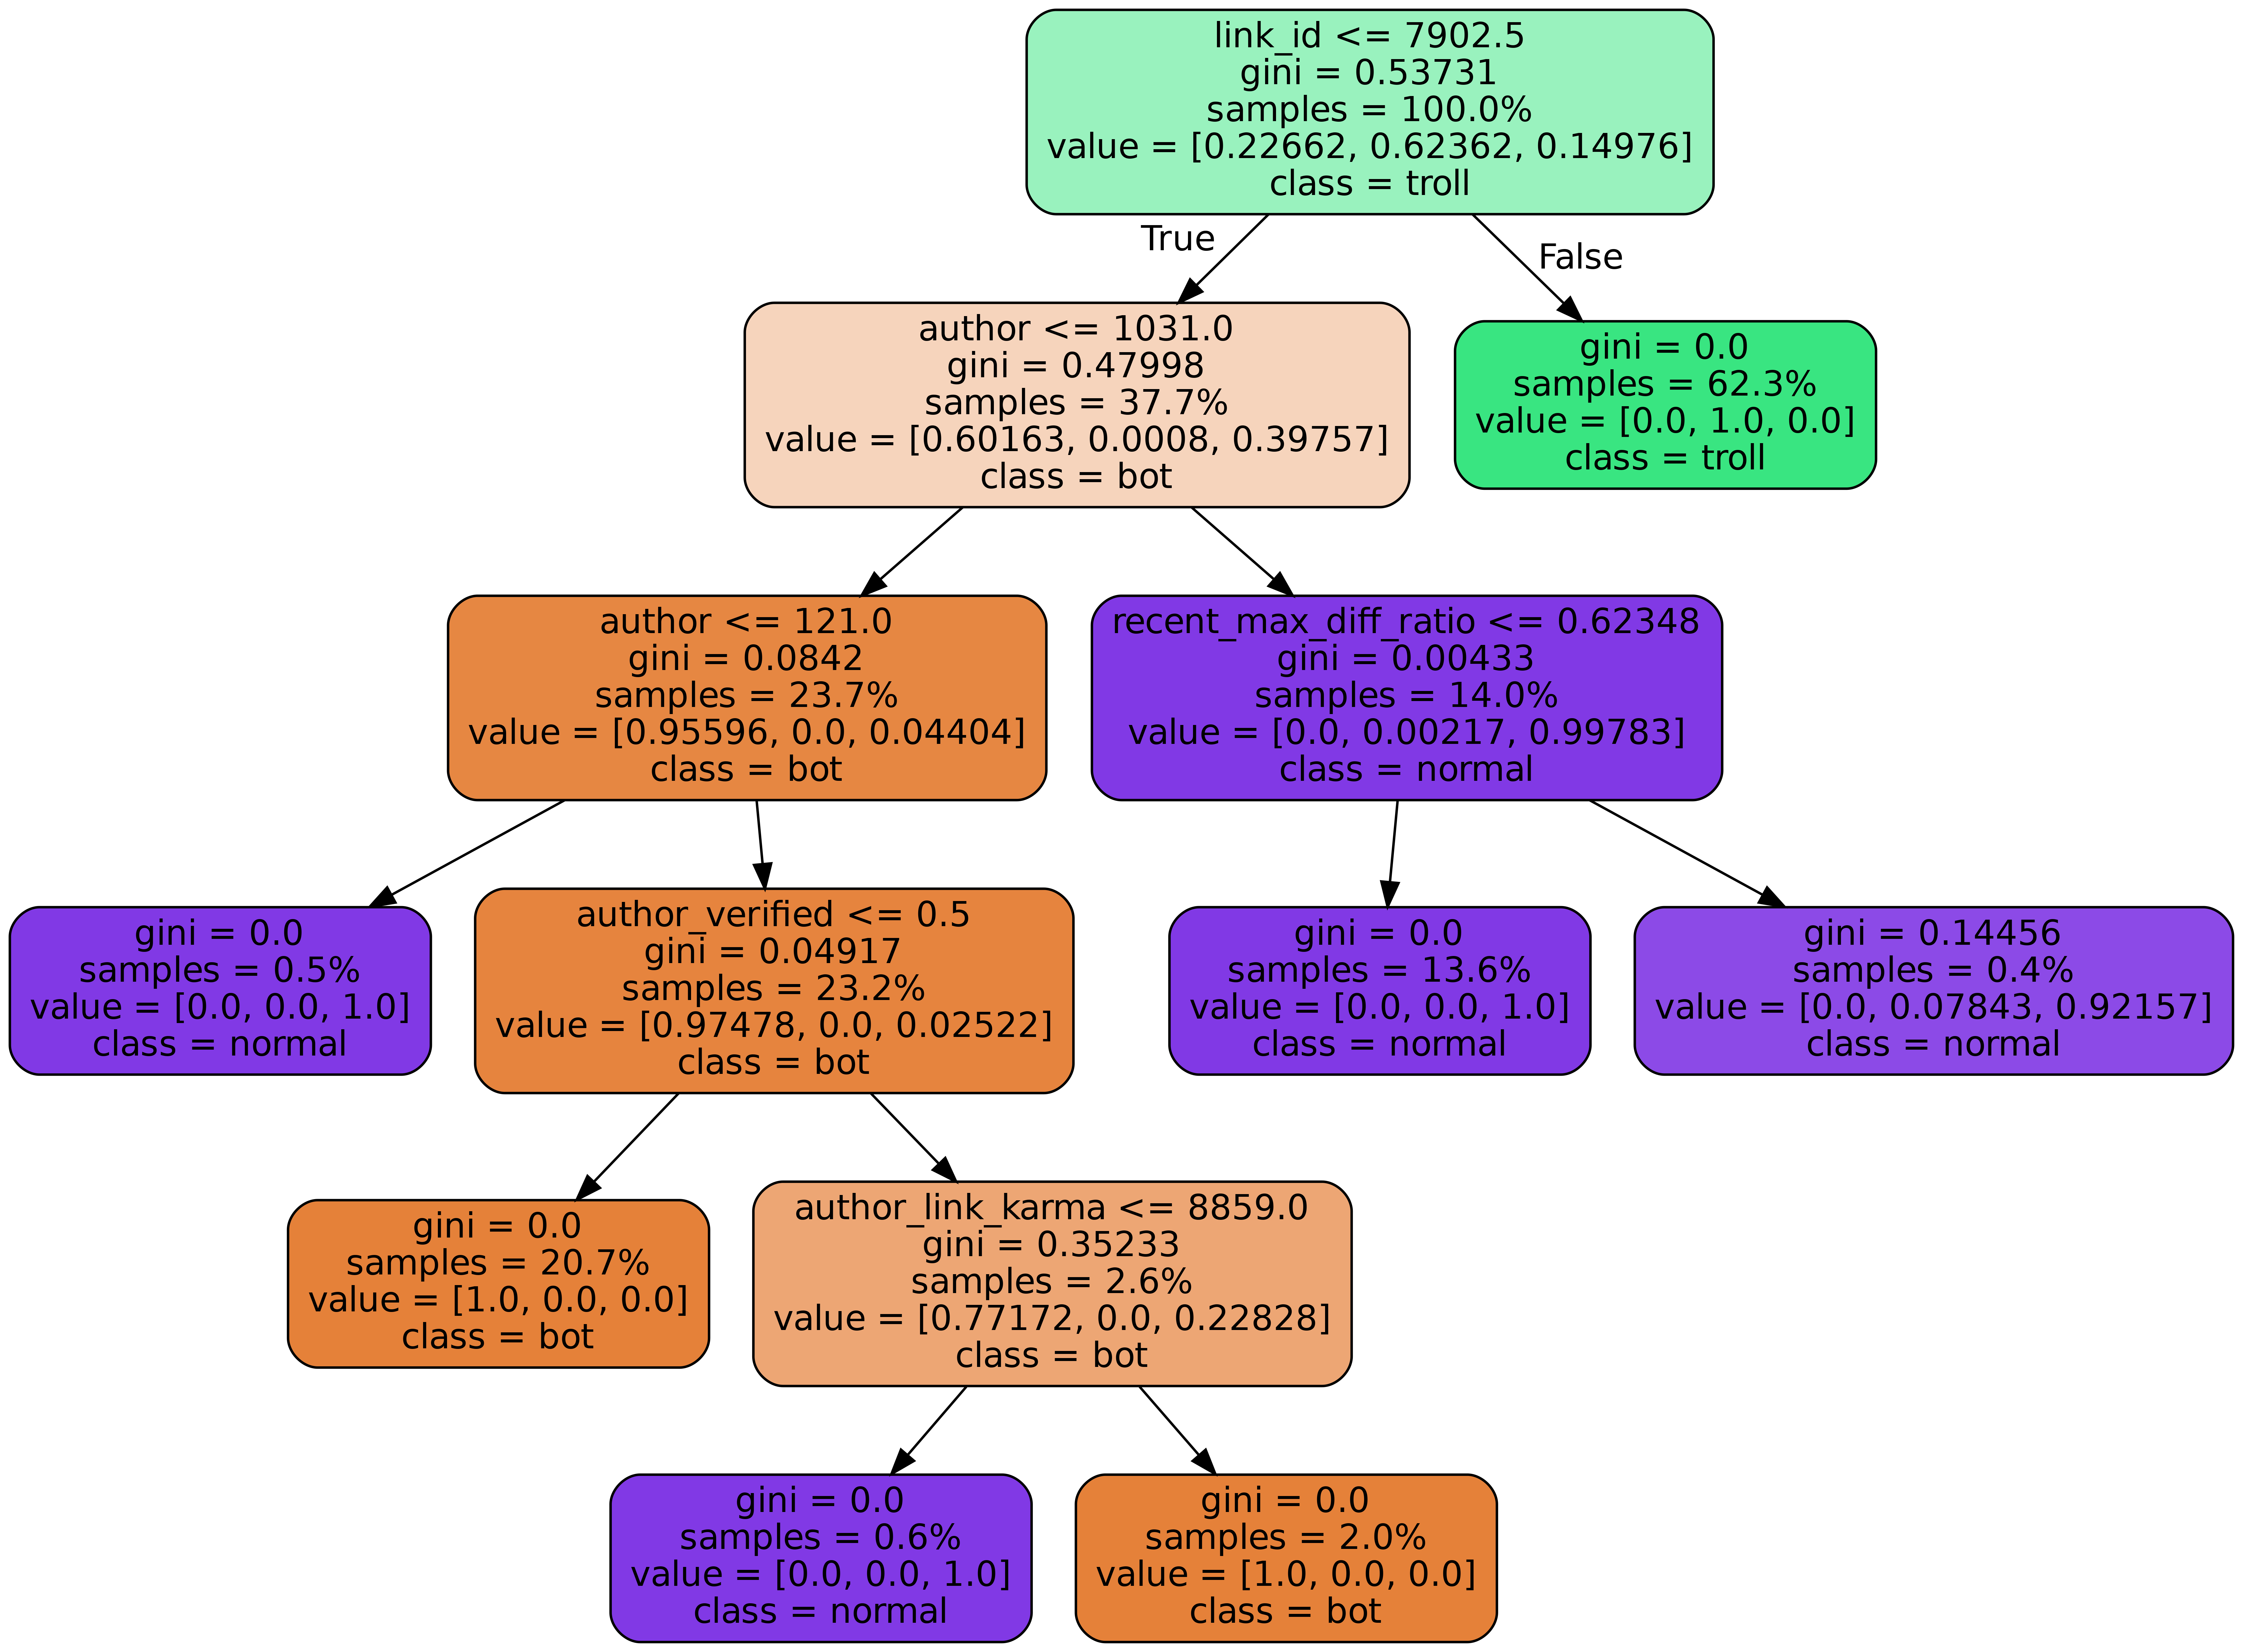

In [254]:
estimator = tree_clf

# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = df.drop(['target'], axis=1).columns.values,
                class_names = np.array(['bot','troll', 'normal']),
                rounded = True, proportion = True, 
                precision = 5, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

### Check for overfitting/underfitting

In [255]:
print('Training set score: {:.4f}'.format(tree_clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(tree_clf.score(X_test, y_test)))

Training set score: 0.9997
Test set score: 0.4728


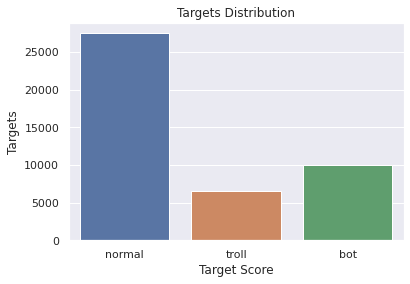

In [256]:
# Plot number of targets
from IPython import get_ipython
import matplotlib.pyplot as plt

ipy = get_ipython()
if ipy is not None:
    ipy.run_line_magic('matplotlib', 'inline')

    # Creating a bar plot
    sns.set(style="darkgrid")
    sns.countplot(x="target", data=df)

    # Add labels to your graph
    plt.xlabel('Target Score')
    plt.ylabel('Targets')
    plt.title("Targets Distribution")
    plt.show()

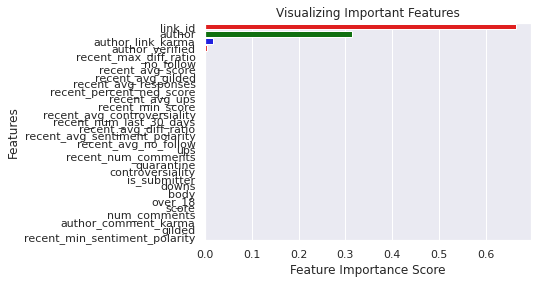

In [257]:
# Visualize the feature importance
ipy = get_ipython()
if ipy is not None:
    ipy.run_line_magic('matplotlib', 'inline')
    
    # Creating a bar plot
    fig, ax = plt.subplots()
    ax = sns.barplot(ax=ax, x=feature_imp, y=feature_imp.index, palette=['red', 'green', 'blue'])
    ax.set_box_aspect(20/len(ax.patches))
    
    # Add labels to your graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.show()

### **Random Forest Classifier Model**

In [258]:
# Creating RandomForestClassifier
forest_clf = RandomForestClassifier(criterion = 'entropy',
                               n_estimators = 30, # The number of Decision tree
                               random_state = 10,
                               n_jobs = 3) # Parallelizing model training
forest_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=30, n_jobs=3,
                       random_state=10)

### Prediction on Test Set


------------------Confusion Matrix------------------
Predicted   bot  normal  troll    All
True                                 
bot        4009       0      0   4009
normal       77    5787   5147  11011
troll         3       0   2601   2604
All        4089    5787   7748  17624


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


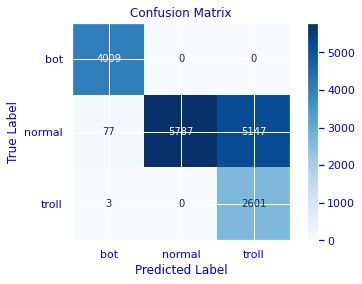


------------------Classification Report------------------
              precision    recall  f1-score   support

         bot       0.98      1.00      0.99      4009
      normal       1.00      0.53      0.69     11011
       troll       0.34      1.00      0.50      2604

    accuracy                           0.70     17624
   macro avg       0.77      0.84      0.73     17624
weighted avg       0.90      0.70      0.73     17624

link_id                          0.348869
author_verified                  0.214410
recent_max_diff_ratio            0.175509
author                           0.077551
recent_avg_diff_ratio            0.047116
author_comment_karma             0.030634
author_link_karma                0.022795
body                             0.020314
ups                              0.018891
score                            0.005318
recent_avg_sentiment_polarity    0.005250
num_comments                     0.004890
recent_avg_responses             0.004533
recent_min_sen

In [259]:
y_pred = forest_clf.predict(X_test)
y_true = y_test

# confusion matrix
print('\n------------------Confusion Matrix------------------')
matrix = pd.crosstab(y_true, y_pred, rownames=['True'],
                     colnames=['Predicted'], margins=True)
print(matrix)
plot_cm(forest_clf, X_test, y_test)

# classification report
print('\n------------------Classification Report------------------')
print(classification_report(y_true, y_pred))

# feature importance
feature_imp = pd.Series(
        forest_clf.feature_importances_,
        index=df.columns.drop('target')).sort_values(ascending=False)
print(feature_imp)

### Check for overfitting/underfitting

In [260]:
print('Training set score: {:.4f}'.format(forest_clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(forest_clf.score(X_test, y_test)))

Training set score: 1.0000
Test set score: 0.7034


### Random Forest Classifier Estimators Diagrams

In [261]:
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (10,10), dpi = 900)
for index in range(0, 4):
    tree.plot_tree(forest_clf.estimators_[index],
                   feature_names = df.drop(['target'], axis=1).columns.values, 
                   class_names = np.array(['bot', 'troll', 'normal']),
                   rounded = True, proportion = True, 
                   precision = 5, filled = True,
                   ax = axes[index])

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
fig.savefig('rf_5trees.png')

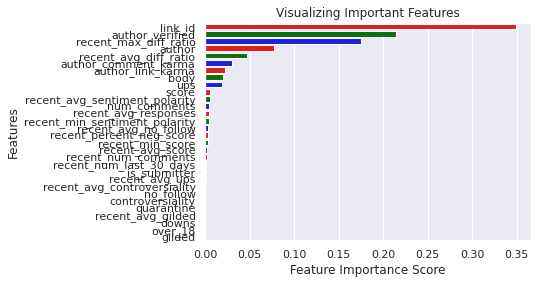

In [262]:
# Visualize the feature importance
ipy = get_ipython()
if ipy is not None:
    ipy.run_line_magic('matplotlib', 'inline')
    
    # Creating a bar plot
    fig, ax = plt.subplots()
    ax = sns.barplot(ax=ax, x=feature_imp, y=feature_imp.index, palette=['red', 'green', 'blue'])
    ax.set_box_aspect(20/len(ax.patches))
    
    # Add labels to your graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.show()

### **Serialize model**

In [270]:
with open('./model.pickle', 'wb') as mof:
    pickle.dump(forest_clf, mof)

## **What's next?**

#### I also developed a **Flask Web API** which exposes the **Reddit Lens ML model** and a **Kafka Cluster** for real-time data streaming to be used by a **Flutter Dashboard Monitor app** in order to help moderators detect trolls and bots on their beloved subreddits. Go check it out on [my github profile](https://github.com/WarriorsSami/reddit_lens)! ;)